# Определение стоимости автомобилей

Сервис по продаже автомобилей с пробегом разрабатывает приложение для привлечения новых клиентов. В нём можно быстро узнать рыночную стоимость своего автомобиля. В нашем распоряжении исторические данные: технические характеристики, комплектации и цены автомобилей. Нам нужно построить модель для определения стоимости. 

Цель проекта — разработать модель, которая будет точно определять стоимость автомобилей на основе предоставленных данных. Заказчик ставит перед проектом три ключевых требования: 
- высокое качество предсказаний, 
- быстрая скорость предсказаний, 
- минимальное время обучения модели.

Для достижения этих целей будет проведено исследование с применением различных моделей машинного обучения, включая как сложные методы, такие как градиентный бустинг, так и более простые алгоритмы. Это позволит выбрать наиболее эффективную модель с точки зрения точности, скорости и времени обучения.

План выполнения проекта:

1. Загрузка и подготовка данных:
- Очистка данных от пропусков, дубликатов и аномалий.
- Подготовка к признаков к обучению модели.
2. Обучение различных моделей:
- Настройка гиперпараметров для моделей. 
- Обучение.
3. Анализ производительности моделей:
- Сравнение моделей по метрике RMSE.
- Оценка скорости предсказаний.
- Оценка времени обучения.

Основная метрика для оценки качества моделей — RMSE (корень из среднеквадратичной ошибки). Это позволит определить, насколько точно модель предсказывает стоимость автомобилей, минимизируя ошибки.

In [1]:
pip install --upgrade pip -q

Note: you may need to restart the kernel to use updated packages.


In [2]:
#pip install --upgrade Pillow -q

In [3]:
#pip install --upgrade numba visions pandas -q

In [4]:
pip install ydata_profiling==4.6.1 -q

Note: you may need to restart the kernel to use updated packages.


In [5]:
pip install -U scikit-learn -q

Note: you may need to restart the kernel to use updated packages.


In [6]:
pip install shap -q

Note: you may need to restart the kernel to use updated packages.


In [7]:
pip install phik -q

Note: you may need to restart the kernel to use updated packages.


In [8]:
pip install category_encoders -q

Note: you may need to restart the kernel to use updated packages.


In [9]:
pip install --upgrade catboost -q

Note: you may need to restart the kernel to use updated packages.


In [10]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import shap
import lightgbm as lgb
import category_encoders as ce
import warnings

from pandas.plotting import scatter_matrix
from phik import phik
from scipy import stats as st
from numpy.random import RandomState
from ydata_profiling import ProfileReport
from time import time

from sklearn.compose import ColumnTransformer
from sklearn.linear_model import LinearRegression, Lasso, Ridge, ElasticNet
from lightgbm import LGBMRegressor
from catboost import CatBoostRegressor, Pool, cv
from sklearn.tree import DecisionTreeRegressor
from sklearn.metrics import (mean_absolute_error, mean_squared_error, r2_score, make_scorer)
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV, train_test_split, cross_val_score
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OneHotEncoder, OrdinalEncoder, StandardScaler
from sklearn.dummy import DummyRegressor

In [11]:
warnings.filterwarnings('ignore')

In [12]:
%matplotlib inline

In [13]:
RANDOM_STATE = 42

## Подготовка данных

### Предобработка

In [14]:
try:
    cars = pd.read_csv('/datasets/autos.csv')
except:
    cars = pd.read_csv('C:/Users/ASUS/Desktop/PRACTICUM/Мои проекты/Cars/autos.csv')

Датасет содержит следующие признаки:

- DateCrawled — дата скачивания анкеты из базы
- VehicleType — тип автомобильного кузова
- RegistrationYear — год регистрации автомобиля
- Gearbox — тип коробки передач
- Power — мощность (л. с.)
- Model — модель автомобиля
- Kilometer — пробег (км)
- RegistrationMonth — месяц регистрации автомобиля
- FuelType — тип топлива
- Brand — марка автомобиля
- NotRepaired — была машина в ремонте или нет
- DateCreated — дата создания анкеты
- NumberOfPictures — количество фотографий автомобиля
- PostalCode — почтовый индекс владельца анкеты (пользователя)
- LastSeen — дата последней активности пользователя
- Price — цена (евро)

In [15]:
ProfileReport(cars, explorative=True)

Summarize dataset:   0%|          | 0/5 [00:00<?, ?it/s]

Generate report structure:   0%|          | 0/1 [00:00<?, ?it/s]

Render HTML:   0%|          | 0/1 [00:00<?, ?it/s]

In [16]:
start_len = len(cars)

Для начала приведем названия колонок к единообразию:

In [17]:
cars.columns = cars.columns.str.lower()
cars.columns = [
       'date_crawled', 'price', 'vehicle_type', 'registration_year', 'gearbox',
       'power', 'model', 'kilometer', 'registration_month', 'fuel_type', 'brand',
       'repaired', 'date_created', 'number_of_pictures', 'postal_code',
       'last_seen'
]

Сразу обращает на себя внимание колонка 'number_of_pictures' - она содержит только одно значение, можем от нее избавиться. Также можно предположить, что признаки, содержащие информацию о датах скачивания анкеты ('date_crawled') и последней активности пользователя ('last_seen'), а также о его почтовом индексе ('postal_code') не пригодятся - их участие в ценообразовании автомобилей маловероятно. Также информация о месяце регистрации авто тоже может быть избыточной - для описания авто достаточно только года регистрации. Из данных о дате создания объявления также сохраним только год, после всех этапов предобработки проверим взаимосвязь этого признака с прочими.

In [18]:
cars['year_created'] = pd.to_datetime(cars['date_created']).dt.year

In [19]:
cars = cars.drop(columns = [
    'number_of_pictures', 'last_seen', 'date_crawled',
    'registration_month', 'date_created', 'postal_code'
])

Колонка с годом регистрации содержит неправдоподобные значения, очевидно появившиеся в результате ошибки. Все значения до 1900 и после 2016 года (год работы с данными) определенно подлежат удалению. Посмотрим, как распределяется количество зарегистрированных авто по десятилетиям в 20 веке, изменим масштаб по оси с количеством авто, чтобы оценить все десятилетия.

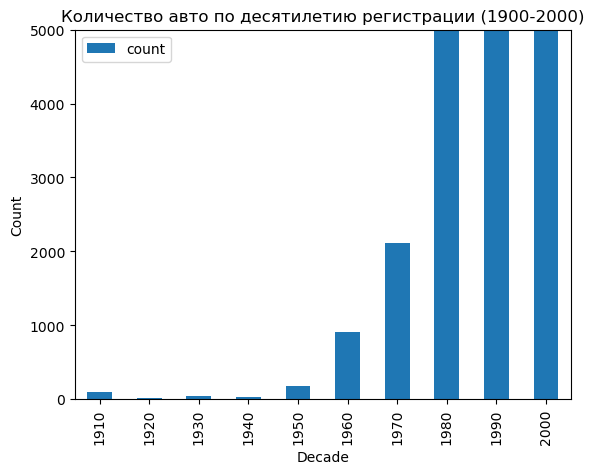

In [20]:
def get_decade(year):
    return (year // 10) * 10

cars['decade'] = cars['registration_year'].apply(get_decade)

grouped_years = cars.groupby('decade').size().reset_index(name='count').query('1900 <= decade <= 2000')

grouped_years.plot(x='decade', y='count', kind='bar')
plt.xlabel('Decade')
plt.ylabel('Count')
plt.title('Количество авто по десятилетию регистрации (1900-2000)')
plt.ylim(0, 5000)
plt.show()

In [21]:
del grouped_years
cars = cars.drop(columns = 'decade')

На графике видно, что до 1960 года было зарегистрировано очень небольшое количество машин, эти записи могут создавать шум в данных, их удаление поможет улучшить качество модели. Таким образом, ограничиваем диапазон годов регистрации периодом 1960-2016 гг. 

In [22]:
cars = cars.query('1960 <= registration_year <= 2016').copy()

Большое количество записей (11.4%) содержат информацию об автомобилях с мощностью двигателя равной нулю. Можно заменить это значение на самую распространенную помощность для модели. Но как нам уже известно, в этом столбце содержатся пропуски. Избавимся от них, заполнив ячейки популярными моделями брендов по годам выпуска авто.

In [23]:
def miss_fill(data, group, fill):
    print('Количество пропусков до заполнения модой')
    print(data[fill].isnull().sum())
    
    data['group_by_year'] = data[group[0]].astype(str) + ' ' + data[group[1]].astype(str)
    mode_group = data.groupby('group_by_year')[fill].apply(lambda x: x.mode().iloc[0] if not x.mode().empty else np.nan)
    data.loc[data[fill].isnull(), fill] = data.loc[data[fill].isnull(), 'group_by_year'].map(mode_group)
    
    data.drop(columns=['group_by_year'], inplace=True)
    
    print('Количество пропусков после заполнения модой')
    print(data[fill].isnull().sum())
    
    return data

In [24]:
cars = miss_fill(cars, ['brand', 'registration_year'], 'model')

Количество пропусков до заполнения модой
17463
Количество пропусков после заполнения модой
3095


Не все пропуски удалось заполнить. Заполним оставшиеся просто модой для бренда, не основываясь на годе выпуска авто.

In [25]:
def miss_fill_one(data, group, fill):
    print('Количество пропусков до заполнения модой')
    print(data[fill].isnull().sum())
    
    mode_group = data.groupby(group)[fill].agg(lambda x: x.mode().iloc[0] if not x.mode().empty else np.nan)
    data['mode_fill'] = data[group].map(mode_group)
    data[fill] = data[fill].fillna(data['mode_fill'])
    data.drop(columns='mode_fill', inplace=True)
    
    print('Количество пропусков после заполнения модой')
    print(data[fill].isnull().sum())
    
    return data

In [26]:
cars = miss_fill_one(cars, 'brand', 'model')

Количество пропусков до заполнения модой
3095
Количество пропусков после заполнения модой
3075


In [27]:
cars[cars['model'].isna()]['brand'].unique()

array(['sonstige_autos'], dtype=object)

Не удалось обнаружить моду для sonstige_autos, эта категория не является реальным брендом автомобилей, а скорее используется для классификации автомобилей, не относящихся к конкретным брендам. Из-за того, что эта категория может содержать разные транспортные средства, ничем не похожие друг на друга, будет лучше избавиться от нее.

In [28]:
cars = cars.query('brand != "sonstige_autos"').copy()

Теперь можно приступить к замене нулевых значений мощности двигателей, используем данные о модели и годе выпуска.

In [29]:
cars['power'] = cars['power'].replace(0, np.nan)

In [30]:
cars = miss_fill(cars, ['model', 'registration_year'], 'power')

Количество пропусков до заполнения модой
35057
Количество пропусков после заполнения модой
296


In [31]:
cars = miss_fill_one(cars, 'model', 'power')

Количество пропусков до заполнения модой
296
Количество пропусков после заполнения модой
2


In [32]:
cars[cars['power'].isna()]['model'].unique()

array(['serie_1'], dtype=object)

In [33]:
cars = miss_fill(cars, ['brand', 'registration_year'], 'power')

Количество пропусков до заполнения модой
2
Количество пропусков после заполнения модой
0


Снова рассмотрим характер распределения данных в столбце 'power' с учетом избавления от нулевых значений.

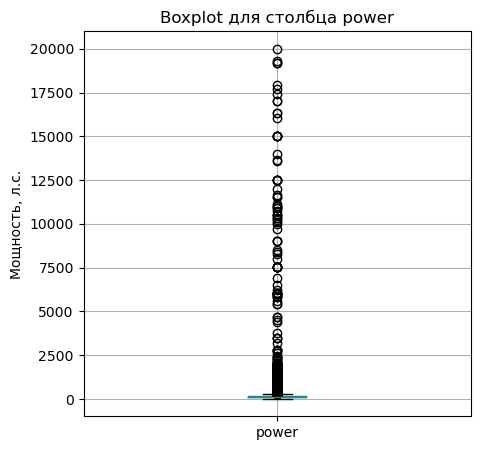

In [34]:
plt.figure(figsize=(5, 5))
cars.boxplot(column='power')
plt.title('Boxplot для столбца power')
plt.ylabel('Мощность, л.с.')
plt.show()

Все строки, содержащие мощность двигателя свыше наиболее реалистичного значения 550 л.с. удалим. 

In [35]:
len(cars.query('power >= 550'))

369

In [36]:
cars = cars.query('power < 550').copy()

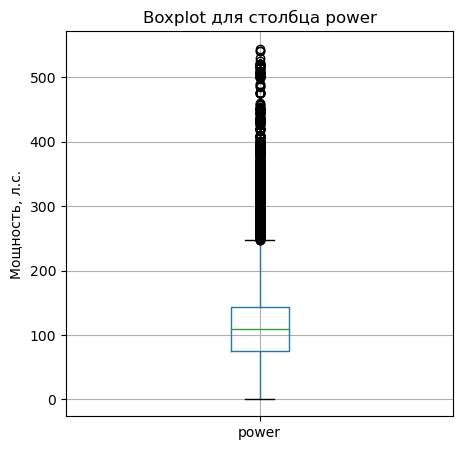

In [37]:
plt.figure(figsize=(5, 5))
cars.boxplot(column='power')
plt.title('Boxplot для столбца power')
plt.ylabel('Мощность, л.с.')
plt.show()

Большое количество авто имеет неправдоподно маленькую мощность двигателя. Возможно, вместо количества лошадиных сил владельцы указывали объем двигателя или киловатты. Удалим строки, содержащие мощность двигателя меньше 20 л.с.

In [38]:
len(cars.query('power < 20'))

225

In [39]:
cars = cars.query('power >= 20').copy()

Судя по гистограмме из исследовательского анализа столбец price значительное количество записей с нулевым значением. Изучим график боксплот. 

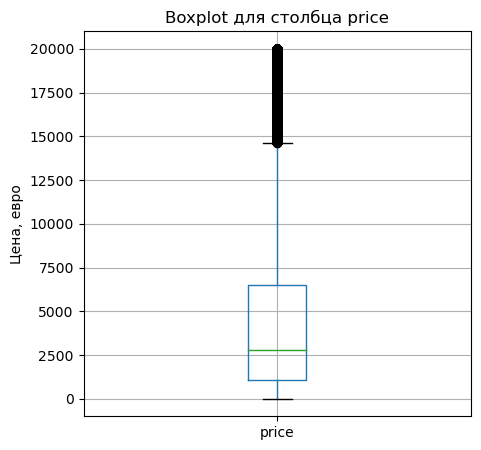

In [40]:
plt.figure(figsize=(5, 5))
cars.boxplot(column='price')
plt.title('Boxplot для столбца price')
plt.ylabel('Цена, евро')
plt.show()

In [41]:
cars['price'].describe()

count    335748.000000
mean       4464.710140
std        4533.929696
min           0.000000
25%        1100.000000
50%        2799.000000
75%        6500.000000
max       20000.000000
Name: price, dtype: float64

При медиане около 2800 среднее значение равно 4500, что указывает на асимметрию в распределении данных. В данных есть несколько очень больших значений, которые тянут среднее значение вверх. Но текущие максимальные значения не являются аномалиями - мы можем только сделать вывод, что рынок поддержанных авто в основном состоит из машин стоимостью до 6500 евро в этом диапазоне умещается 75% выборки, а дорогие авто встречаются реже, но их цена выглядит акдекватно в масштабах нашего набора данных. По-настоящему странно встречать объявления о продаже с ценой менее 100 евро. Изучим график гистограммы для автомобилей дешевле 1000 евро.

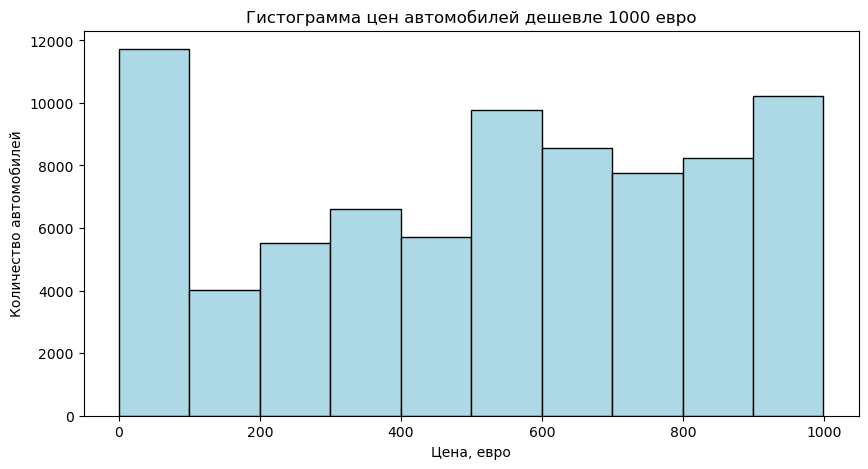

In [42]:
plt.figure(figsize=(10, 5))
plt.hist(cars[cars['price'] < 1000]['price'], bins=10, edgecolor='black', color='lightblue')

plt.title('Гистограмма цен автомобилей дешевле 1000 евро')
plt.xlabel('Цена, евро')
plt.ylabel('Количество автомобилей')

plt.show()

Среди группы недорогих машин цена до 100 евро встречается чаще всех.

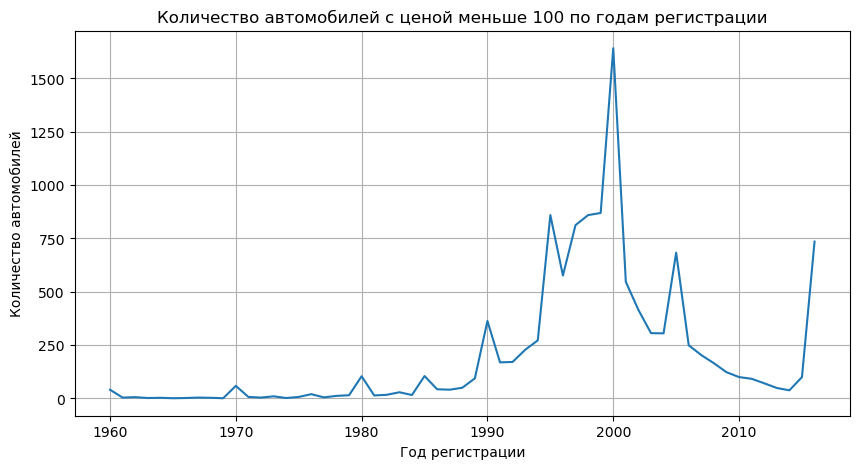

In [43]:
plt.figure(figsize=(10, 5))
cars[cars['price'] < 100].groupby('registration_year')['price'].count().plot()
plt.xlabel('Год регистрации')
plt.ylabel('Количество автомобилей')
plt.title('Количество автомобилей с ценой меньше 100 по годам регистрации')
plt.grid(True)
plt.show()

В основном по заниженной цене продаются авто, зарегистрированные в период 1994-2005 г., что соответствует характеру распределения возраста авто для всех данных, но максимумальное количесвто относится к 2000 году. По по какой-то причине, среди подозрительно дешевых автомобилей есть относительно большое количество машин, зарегистрированных в 2016 году.

In [44]:
len(cars.query('price < 100 and registration_year == 2016'))

735

In [45]:
cars.query('price < 100 and registration_year == 2016').head()

price vehicle_type  registration_year gearbox  power   model  kilometer  \
466       0          NaN               2016    auto  197.0     3er     150000   
890       0          NaN               2016     NaN   75.0   other     150000   
1340      1          NaN               2016  manual   75.0    golf     150000   
1788     80          NaN               2016     NaN   60.0  fiesta       5000   
1793      0          NaN               2016  manual  110.0    golf     150000   

     fuel_type       brand repaired  year_created  
466   gasoline         bmw       no          2016  
890   gasoline     citroen      NaN          2016  
1340  gasoline  volkswagen      yes          2016  
1788       NaN        ford      yes          2016  
1793  gasoline  volkswagen      NaN          2016

In [46]:
cars.query('price < 100 and registration_year == 2016')['vehicle_type'].isna().sum()

711

Почти у всех подозрительных машин 2016 года отсутствует указание типа кузова. Из-за того, что цена для нашего исследования является целевым признаком, удалим строки, где стоимость автомобиля составляет меньше 100 евро.

In [47]:
cars = cars.query('price >=200').copy()

Теперь можно заполнить пропущенные значения в типе кузова ('vehicle_type'). Поступим также, как при заполнении пропусков в столбце 'power': самым популярным значением для этой модели в известный год выпуска. 

In [48]:
cars = miss_fill(cars, ['model', 'registration_year'], 'vehicle_type')

Количество пропусков до заполнения модой
17307
Количество пропусков после заполнения модой
2705


In [49]:
cars = miss_fill_one(cars, 'model', 'vehicle_type')

Количество пропусков до заполнения модой
2705
Количество пропусков после заполнения модой
0


Посмотрим, как теперь распределяются значения в категории 'vehicle_type':

In [50]:
def plotbar_with_perc(data, column):
    
    plt.figure(figsize=(8, 5))
    sns.barplot(x=data[column].value_counts().values, y=data[column].value_counts().index, palette='Accent')

    for i, v in enumerate(data[column].value_counts().values):
        plt.text(v + 0.2, i, f'{v / float(len(data)):.2%}', va='center')

    plt.title(f'Распределение по {column.lower()}', fontdict={'fontsize': 12})
    plt.xlabel('Count')
    plt.ylabel(column)
    plt.show()

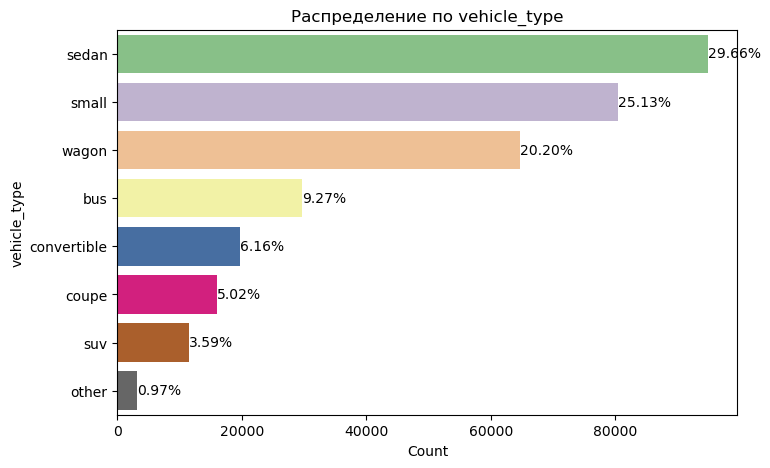

In [51]:
plotbar_with_perc(cars, 'vehicle_type')

Распределение типов кузова не изменилось.

Теперь заполним пропуски в данных о коробке передач, основываясь на данных о модели и мощности двигателя. 

In [52]:
cars = miss_fill(cars, ['model', 'power'], 'gearbox')

Количество пропусков до заполнения модой
13305
Количество пропусков после заполнения модой
114


In [53]:
cars = miss_fill_one(cars, 'model', 'gearbox')

Количество пропусков до заполнения модой
114
Количество пропусков после заполнения модой
0


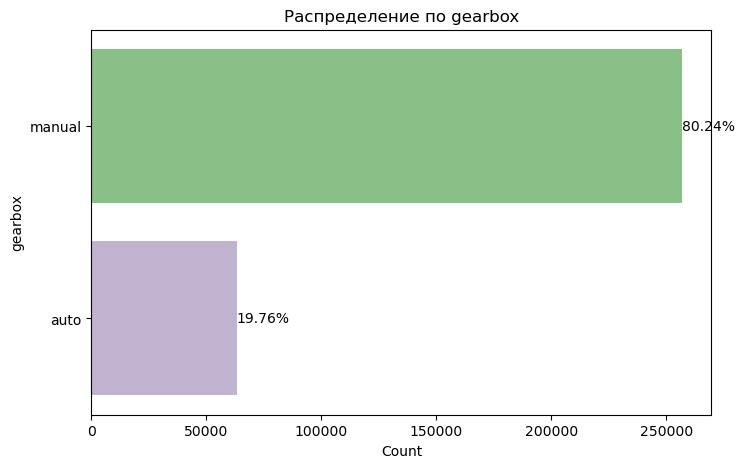

In [54]:
plotbar_with_perc(cars, 'gearbox')

Автомобили с автоматической коробкой передач составляют всего 21%, с механической коробкой передач являются неоспоримым большинством - 79%.

Перед тем, как заполнить пропуске в столбце с данными о типе топлива, рассмотрим подробнее уникальные значения.

In [55]:
cars['fuel_type'].unique()

array(['petrol', 'gasoline', nan, 'lpg', 'other', 'hybrid', 'cng',
       'electric'], dtype=object)

Термины 'petrol' и 'gasoline' в русском языке означают 'бензин', единственная разница между ними - регион использования термина: в американском английском характерно употребление gasoline, а в международном английском - petrol. Объединим эти категории в одну - 'petrol'.

In [56]:
cars['fuel_type'].replace('gasoline', 'petrol', inplace=True)

In [57]:
cars['fuel_type'].unique()

array(['petrol', nan, 'lpg', 'other', 'hybrid', 'cng', 'electric'],
      dtype=object)

Заполним пропуски в данных о виде топлива популярными категориями, исходя о сведениях о марке и мощности двигателя.

In [58]:
cars = miss_fill(cars, ['model', 'power'], 'fuel_type')

Количество пропусков до заполнения модой
21389
Количество пропусков после заполнения модой
373


In [59]:
cars = miss_fill_one(cars, 'model', 'fuel_type')

Количество пропусков до заполнения модой
373
Количество пропусков после заполнения модой
0


Мы объединили две самых крупных категории топлива. Построим график, чтобы увидеть, как сейчас распределены значения в этом столбце.

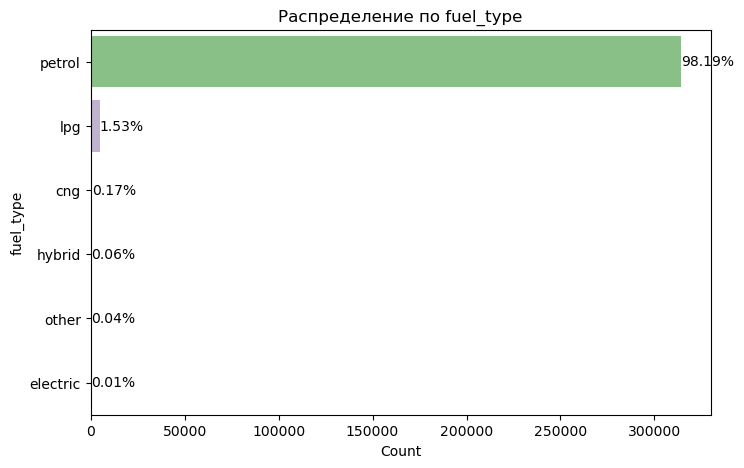

In [60]:
plotbar_with_perc(cars, 'fuel_type')

Данные сильно несбалансированы, почти 98% записей принадлежат мажорному классу - 'petrol'.

Пропущенные значения в столбце 'repaired' заполним на основании предположения о том, что владельцы пропускали это поле в анкете, когда их машина не была в ремонте на момент составления объявления, т.е. заменим nan на 'no'.

In [61]:
cars['repaired'] = cars['repaired'].fillna('no')

Снова посмотрим на баланс данных по признаку 'repaired'.

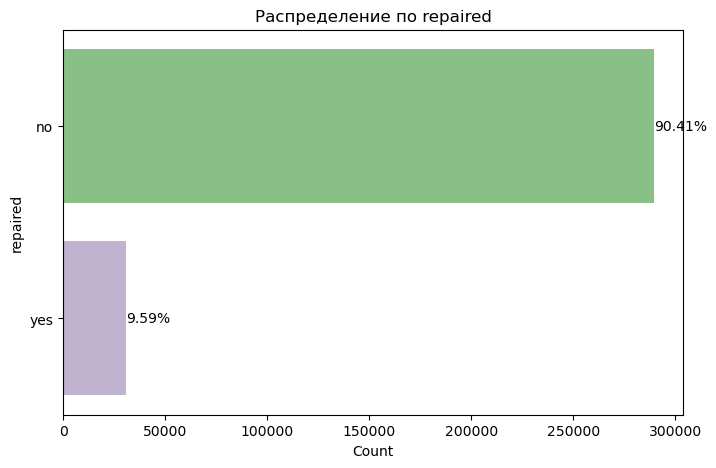

In [62]:
plotbar_with_perc(cars, 'repaired')

Снова сталкиваемся с дисбалансом.

In [63]:
(
    cars.isna()
    .agg(['sum', lambda x: x.mean()*100]).T
    .astype({'sum': 'int'})
    .rename(columns={'sum': 'Количество пропусков', '<lambda>': 'Процент пропусков'})
)

Количество пропусков  Процент пропусков
price                                 0                0.0
vehicle_type                          0                0.0
registration_year                     0                0.0
gearbox                               0                0.0
power                                 0                0.0
model                                 0                0.0
kilometer                             0                0.0
fuel_type                             0                0.0
brand                                 0                0.0
repaired                              0                0.0
year_created                          0                0.0

После того, как мы избавились от пропусков, перепроверим наличие дубликатов.

In [64]:
print(f'Количество дубликатов в датасете: {cars.duplicated().sum()}')
print(f'Доля дубликатов в датасете: {cars.duplicated().sum()/len(cars):.2%}')

Количество дубликатов в датасете: 59951
Доля дубликатов в датасете: 18.73%


Почти 19% всех имеющихся данных придется удалить.

In [65]:
cars = cars.drop_duplicates()

In [66]:
cars.duplicated().sum()

0

Снова посмотрим на таблицу корреляций:

In [67]:
interval_cols = ['price', 'power']

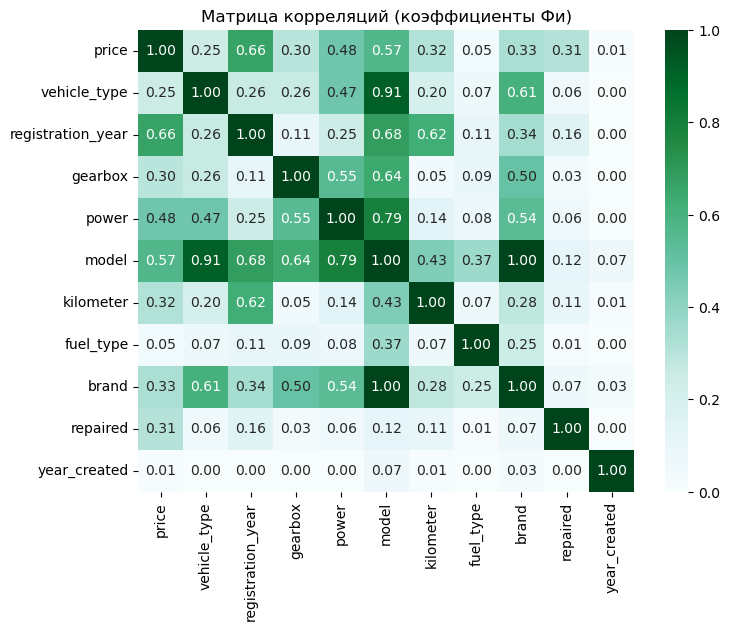

In [68]:
plt.figure(figsize=(8, 6))
sns.heatmap(cars.phik_matrix(interval_cols=interval_cols), annot=True, fmt='.2f', cmap='BuGn')
plt.title('Матрица корреляций (коэффициенты Фи)', fontdict={'fontsize': 12})
plt.show()

Сильнее всего с целевым признаком связан год регистрации авто, модель и мощность двигателя. Присутствует мультиколлинеарность между признаками: тип кузова и модель, модель и бренд. Год размещения объявления не коррелирует ни с одним признаком, удалим его.

In [69]:
cars = cars.drop(columns = 'year_created', axis=1)

In [70]:
cars = cars.drop_duplicates()

In [71]:
print(f'Количество строк в датасете уменьшилось на {(start_len-len(cars))/start_len:.1%} по сравнению с исходным размером.')

Количество строк в датасете уменьшилось на 26.6% по сравнению с исходным размером.


### Подготовка к обучению

Первой моделью, которую мы обучим будет регрессия, для этого необходимо закодировать категориальные признаки, но для бустинговых моделей мы просто передадим список категориальных признаков при создании и обучении модели.

In [72]:
print(f'Количество уникальных значений в каждом столбце:\n{cars.nunique()}')

Количество уникальных значений в каждом столбце:
price                3560
vehicle_type            8
registration_year      57
gearbox                 2
power                 402
model                 250
kilometer              13
fuel_type               6
brand                  39
repaired                2
dtype: int64


In [73]:
X = cars.drop(columns='price')
y = cars.price

In [74]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y,
    test_size = 0.25, 
    random_state = RANDOM_STATE
)

X_train.shape, X_test.shape

((195038, 9), (65013, 9))

Для кодирования мы будем использовать два кодировщика: MEstimateEncoder для 'model' и 'brand' (из-за большого количества категорий) и OneHotEncoder для остальных категориальных переменных. Кодирование произведем с помощью пайплайна. Чтобы избежать утечки целевого признака, мы произвели разделение на обучающую и тестовую выбоки заранее, так как MEstimateEncoder использует значения целевого признака для кодирования.

In [75]:
cols_ohe = ['vehicle_type', 'gearbox', 'fuel_type', 'repaired', 'kilometer']
cols_ord = ['model', 'brand', 'registration_year']
cols_num = ['power']

In [76]:
preprocessing = ColumnTransformer(
    transformers=[
        ('ohe', Pipeline([
            ('encoder', OneHotEncoder(drop='first', handle_unknown='ignore')),
        ]), cols_ohe),
        
        ('mestimator', Pipeline([
            ('encoder', ce.MEstimateEncoder(cols=cols_ord, m=5)),
            ('simpleImputer_after_ord', SimpleImputer(missing_values=np.nan, strategy='most_frequent')),
            ('scaler', StandardScaler())
        ]), cols_ord),
        
        ('num', StandardScaler(), cols_num)
    ]
)

pipe_final = Pipeline(
    [
        ('preprocessor', preprocessing),
        ('models', LinearRegression())
    ]
)

Создадим функцию скоринга, которая будет вычислять RMSE (функцию издержек). 

In [77]:
def rmse(y_true, y_pred):
    return np.sqrt(mean_squared_error(y_true, y_pred))
rmse_scorer = make_scorer(rmse, greater_is_better=False)

**Вывод**

В ходе предобработки данных было удалено 26,6% строк. Диапазон годов регистрации был сужен до рамок 1960-2016 гг. Мощность двигателей была ограничена правдоподобными значениями, ограниченными диапазоном 20-550 л.с. Из исследования были исключены записи об автомобилях, цена которых составляла меньше 100 евро. Было произведено объединение двух категорий в признаке "тип топлива" из-за их тождественности: "gasoline" и "petrol" яляются бензином и никаких качественных различий не имеют. Пропущенные значения в датасете были заполнены наиболее часто встречающимися значениями, основываясь на известных данных, так, например, пропуски в моделях мы заполнили популярными моделями брендов, которые были выпущены в известном году, а также значениями, которые пользователи не указвали из-за очевидности отсутствия признака. В ходе исследования были выявлены сильные дисбалансы классов в признаках 'fuel_type' (мажорный класс - 'petrol', 98%), 'gearbox' ('manual', 79%), 'repaired' ('no', 89%). Доля дубликатов, которые были выявлены после удаления нерелевантных строк, а также сокращения количества признаков, составила 18,7%, все дублирующиеся строки были удалены. Сильнее всего с целевым признаком (цена) взаимосвязаны год регистрации авто, модель и мощность двигателя. Присутствует мультиколлинеарность между признаками: тип кузова и модель, модель и бренд. Среди несбалансированных признаков заметной взаимосвязью с целевым обладают 'gearbox' и 'repaired'. Для обучения модели линейной регресии необходимо закодировать категориальные признаки. Мы используем OrdinalEncoder для столбца 'model' (из-за большого количества категорий) и OneHotEncoder для остальных категориальных переменных. Кодирование осуществляется с помощью пайплайна. Затем данные были разделены в пропорции 60% на тренировочную выборку и по 20% на тестовую и валидационную.

## Обучение моделей

Для решения задачи определения стоимости автомобилей рассмотрим три модели: линейной регрессии, при этом рассмотрим три варианта: Ridge регрессия, ElasticNet и обычная линейная регрессия (LinearRegression), а затем перейдем к более сложным алгоритмам: градиентному бустингу LightGBM и CatBoost.

### Модель линейной регрессии

In [78]:
param_grid = [
    {
        'models': [Ridge(random_state=RANDOM_STATE)],
        'models__alpha': [0.01, 0.1, 1.0, 10.0],
        'models__solver': ['auto', 'sag'],
        'models__fit_intercept': [True, False]
    },
    {
        'models': [LinearRegression()],
        'models__fit_intercept': [True, False]
    },
    {
        'models': [ElasticNet(random_state=RANDOM_STATE)],
        'models__alpha': [0.01, 0.1, 1.0, 10.0],
        'models__l1_ratio': [0.1, 0.5, 0.9],
        'models__fit_intercept': [True, False]
    }
]

In [79]:
random_search = RandomizedSearchCV(
    pipe_final,
    param_grid,
    cv=5,
    scoring = rmse_scorer,
    random_state=RANDOM_STATE,
    n_iter=30,
    n_jobs=-1
)

In [80]:
random_search.fit(X_train, y_train)

print(f'Лучшие параметры: {random_search.best_params_}')
print(f'Лучшая метрика RMSE на кросс-валидации: {random_search.best_score_*-1}')

Лучшие параметры: {'models__fit_intercept': True, 'models': LinearRegression()}
Лучшая метрика RMSE на кросс-валидации: 2291.822073351701


In [81]:
pd.set_option('display.max_colwidth', None)
result = pd.DataFrame(random_search.cv_results_) 
result['mean_test_score'] = result['mean_test_score']*-1
result['name'] = result['param_models'].apply(lambda x: str(x).split('(')[0])
best_results = (result
                .loc[result.groupby('name')['mean_test_score'].idxmin()]
                [['rank_test_score', 'name', 'params', 'mean_test_score', 'mean_fit_time', 'mean_score_time']]
                .sort_values('rank_test_score'))
best_results

rank_test_score              name  \
16                1  LinearRegression   
1                 2             Ridge   
6                10        ElasticNet   

                                                                                                                    params  \
16                                                           {'models__fit_intercept': True, 'models': LinearRegression()}   
1        {'models__solver': 'sag', 'models__fit_intercept': True, 'models__alpha': 10.0, 'models': Ridge(random_state=42)}   
6   {'models__l1_ratio': 0.5, 'models__fit_intercept': True, 'models__alpha': 0.01, 'models': ElasticNet(random_state=42)}   

    mean_test_score  mean_fit_time  mean_score_time  
16      2291.822073       2.460578         0.225439  
1       2291.866688       2.282195         0.224426  
6       2294.528789       4.745617         0.356621

In [82]:
names = []
scores = []
fit_times = []
score_times = []

for i in range(3):
    names.append(best_results.iloc[i, 1])
    scores.append(best_results.iloc[i, 3])
    fit_times.append(best_results.iloc[i, 4])
    score_times.append(best_results.iloc[i, 5])

In [83]:
best_lr_model = random_search.best_estimator_
best_lr_model.fit(X_train, y_train)
y_lr_pred = best_lr_model.predict(X_train)

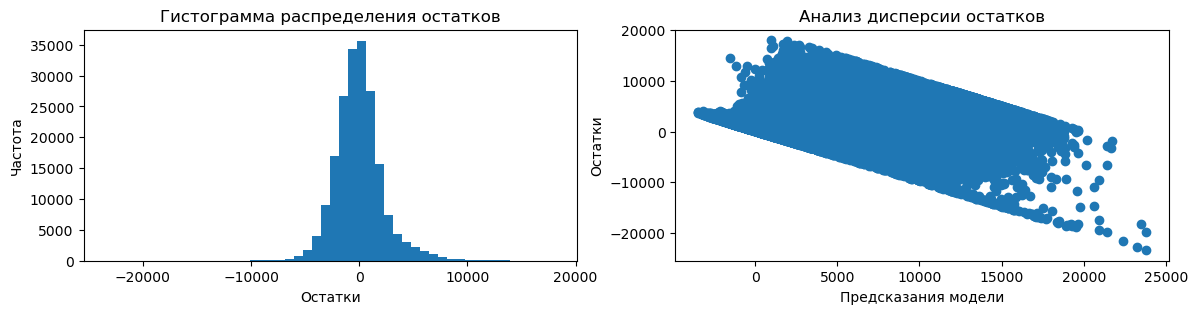

In [84]:
residuals = y_train - y_lr_pred
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(14,3))
axes[0].hist(residuals, bins=50)
axes[0].set_title('Гистограмма распределения остатков')
axes[0].set_xlabel('Остатки')
axes[0].set_ylabel('Частота')

axes[1].scatter(x=y_lr_pred, y=residuals)
axes[1].set_xlabel('Предсказания модели')
axes[1].set_ylabel('Остатки')
axes[1].set_title('Анализ дисперсии остатков')
plt.show()

Большинство остатков сгруппировано около нуля, график немного смещен влево. Судя по графику рассеяния, остатки распределены неслучайным образом - график их значений по модулю симметричен около предсказания 7500.

In [85]:
def predict_true_plot(y_train, y_pred):
    plt.figure(figsize=(8, 6))
    sns.regplot(x=y_train, y=y_pred)
    plt.ylabel('Предсказанные значения')
    plt.xlabel('Фактические значения')
    plt.title('Отношение между реальными и предсказанными значениями')
    plt.plot([y_train.min(), y_train.max()], [y_train.min(), y_train.max()], 'k--', lw=2)
    plt.show()

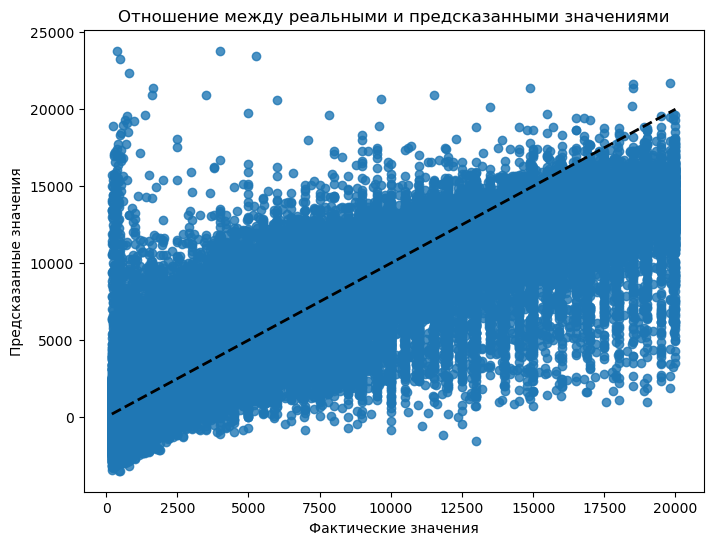

In [86]:
predict_true_plot(y_train, y_lr_pred)

Если бы модель имела хорошие предсказательные свойства, прогнозные и фактические значения находились близко к прямой, несмотря на то, что график имеет небольшой наклон, о хорошем качестве модели мы не можем. Модель сильно завышает прогнозную стоимость авто до 1000.

Рассмотрим природу отношений между признаками.

In [87]:
X_train_new = pipe_final.named_steps['preprocessor'].fit_transform(X_train, y_train)
X_train_dense = X_train_new.toarray()

In [88]:
feature_names = pipe_final.named_steps['preprocessor'].get_feature_names_out()
explainer = shap.LinearExplainer(best_lr_model.named_steps['models'], X_train_new)

In [89]:
X_train_new_df = pd.DataFrame(X_train_dense, columns=feature_names)

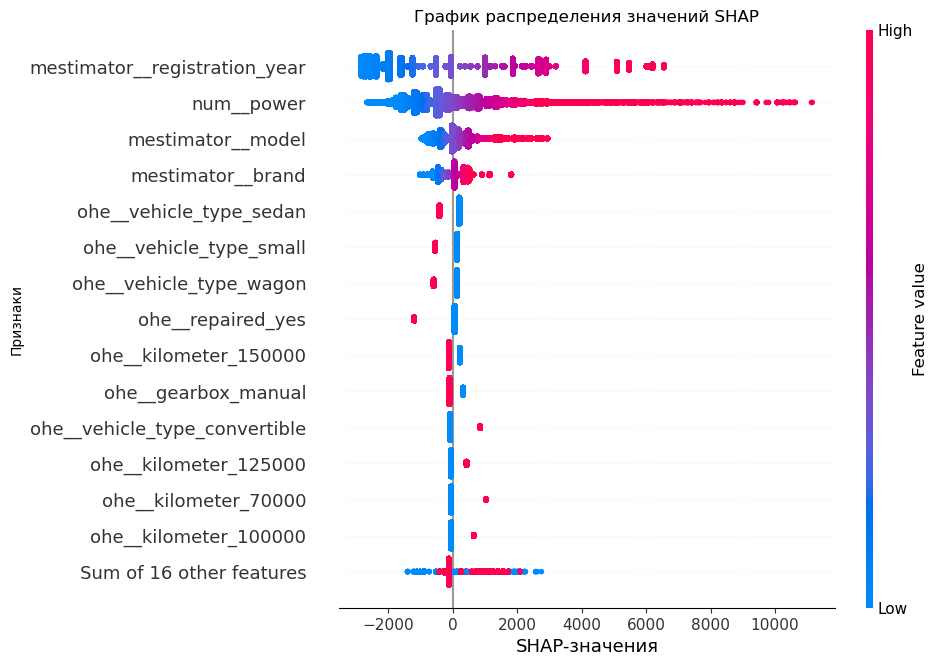

In [90]:
shap_values = explainer(X_train_new_df)
fig, ax = plt.subplots()
shap.plots.beeswarm(shap_values, max_display=15, show=False)
ax.set_xlabel('SHAP-значения')
ax.set_ylabel('Признаки')
ax.set_title('График распределения значений SHAP')
plt.show()

Судя по графику, высокие показатели мощности двигателя соответствуют более высоким спрогнозированным ценам авто. Также модель сочла признаки год регистрации, модель и бренд наиболее важными при прогнозировании. 

### Модель LightGBM

Для более глубокого изучения модели LightGBM используем два разных подхода: сначала для обучения используем способ lgb.train - он напрямую использует API LightGBM, при этом вручную зададим гиперпараметры, а затем используем LGBMRegressor интегрированный с API scikit-learn, что позволит легко использовать GridSearchCV для перебора комбинаций гиперпараметров.

In [91]:
categorical_feature_names = ['vehicle_type', 'gearbox', 'brand', 'fuel_type', 'repaired', 'model']
for c in categorical_feature_names:
    X_train[c] = X_train[c].astype('category')

In [92]:
train_dataset = lgb.Dataset(X_train, label=y_train, 
                            feature_name=X_train.columns.tolist(),
                            categorical_feature=categorical_feature_names)

In [93]:
%%time
params = {'objective': 'regression', 'metric': 'rmse'}


booster = lgb.train(
    params, 
    train_set=train_dataset, 
    num_boost_round=500,
    categorical_feature=categorical_feature_names
)

[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.004338 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 604
[LightGBM] [Info] Number of data points in the train set: 195038, number of used features: 9
[LightGBM] [Info] Start training from score 4905.868456
CPU times: total: 12.8 s
Wall time: 1.68 s


In [94]:
%%time
y_boost_pred = booster.predict(X_train)

CPU times: total: 9.06 s
Wall time: 1.14 s


In [95]:
print(f'Лучшая метрика RMSE: {rmse(y_train, y_boost_pred):.4f}')
print(f'Количество деревьев в модели: {booster.num_trees()}')

Лучшая метрика RMSE: 1518.4556
Количество деревьев в модели: 500


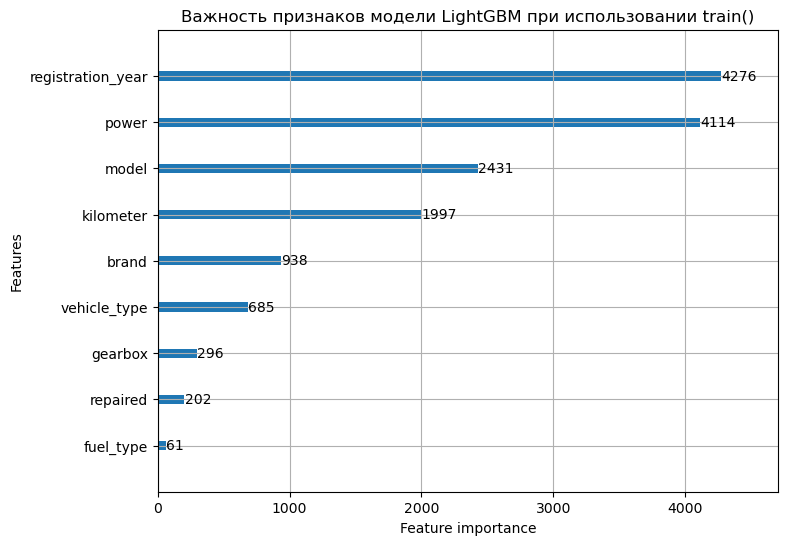

In [96]:
ax=lgb.plot_importance(booster, figsize=(8,6))
ax.set_title('Важность признаков модели LightGBM при использовании train()')
plt.show()

По умолчанию бустер использует скорость обучения 0,1 и минимизирует потерю l2 для задачи регрессии. В процессе обучения модели были обучены 500 деревьев. Самыми важными признаками являются год регистрации авто, мощность двигателя и модель. Метрика rmse получилась значительно ниже, чем для линейной регрессии, модель могла переобучиться на тренировочных данных, что привело к низкому значению ошибки на этих данных. Для ознакомления с методом этого достаточно.

На кросс-валидации рассмотрим работу LGBMRegressor из библиотеки LightGBM. Параметр n_estimators является псевдонимом параметра num_boost_round метода train(), в нем мы попробуем два значения: 500 и 1000 деревьев в ансамбле для создания оценщика, а также найдем оптимальное значение регуляризации для модели (reg_lambda, также известный как L2-регуляризация).  

Результат по метрике RMSE по сравнению с простой линейной моделью уже гораздо лучше.

In [97]:
%%time
model_LGBMR = LGBMRegressor(metric='rmse')

param_grid_LGBMR = {
    'n_estimators': [500, 1000],
    'reg_lambda': [0.0, 0.1]
}

grid_search_LGBMR = GridSearchCV(estimator=model_LGBMR, param_grid=param_grid_LGBMR, 
                           cv=5, scoring=rmse_scorer, verbose=0, n_jobs=-1)

grid_search_LGBMR.fit(X_train, y_train)

print('Лучшие параметры модели LGBMRegressor: ', grid_search_LGBMR.best_params_)
print('Лучшая метрика на кросс-валидации: ', grid_search_LGBMR.best_score_*-1)

[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.006087 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 604
[LightGBM] [Info] Number of data points in the train set: 195038, number of used features: 9
[LightGBM] [Info] Start training from score 4905.868456
Лучшие параметры модели LGBMRegressor:  {'n_estimators': 1000, 'reg_lambda': 0.1}
Лучшая метрика на кросс-валидации:  1649.1763378896635
CPU times: total: 18.4 s
Wall time: 1min 8s


In [98]:
rmse_LGBMR = grid_search_LGBMR.best_score_*-1

In [99]:
best_model_LGBMR = grid_search_LGBMR.best_estimator_

In [100]:
start_1 = time()
best_model_LGBMR.fit(X_train, y_train)
end_1 = time()

[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.006937 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 604
[LightGBM] [Info] Number of data points in the train set: 195038, number of used features: 9
[LightGBM] [Info] Start training from score 4905.868456


In [101]:
LGBMR_fit_time = end_1 - start_1
LGBMR_fit_time

4.00063419342041

In [102]:
start_2 = time()
y_LGBMR_pred = best_model_LGBMR.predict(X_train)
end_2 = time()

In [103]:
LGBMR_pred_time = end_2 - start_2
LGBMR_pred_time

4.227224349975586

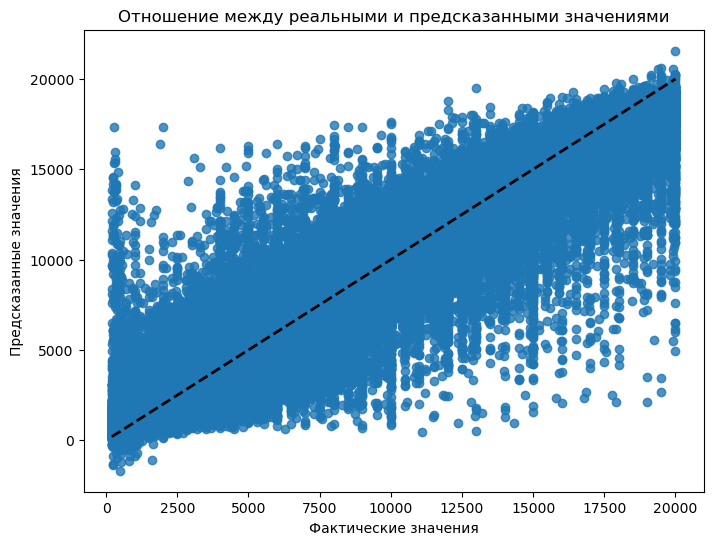

In [104]:
predict_true_plot(y_train, y_LGBMR_pred)

На графике зависимости предсказанных и реальных значений мы видим гораздо меньше отрицательных предсказаний, чем для модели линейной регрессии, но они по-прежнему присутствуют. Наклон графика соответствует наклону линии идеальных предсказаний, но значения сильно рассеяны. Особенно плохо модель прогнозирует цену автомобилей самого дешевого сегмента (до 1000). График не отображает полной картины, потому что мы оцениваем пресказания по тренировочной выборке, но общие тренды понятны.

In [105]:
importance = best_model_LGBMR.booster_.feature_importance()
feature_names = best_model_LGBMR.booster_.feature_name()

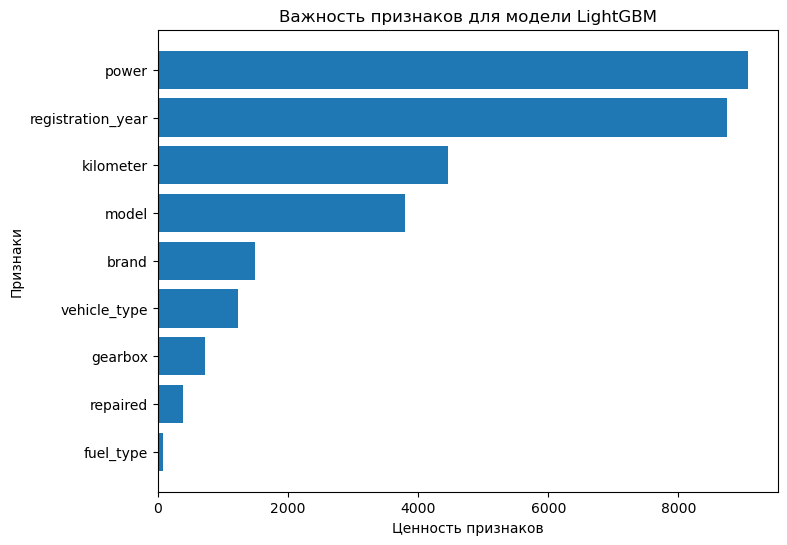

In [106]:
importance_LGBMR = pd.DataFrame({
    'Признак': feature_names,
    'Важность': importance
}).sort_values(by='Важность', ascending=False)

plt.figure(figsize=(8, 6))
plt.barh(importance_LGBMR['Признак'], importance_LGBMR['Важность'])
plt.xlabel('Ценность признаков')
plt.ylabel('Признаки')
plt.title('Важность признаков для модели LightGBM')
plt.gca().invert_yaxis()
plt.show()

Как и при обучении модели линейной регрессии, наибольший вклад в предсказания модели вносят признаки: мощность двигателя и год регистрации. 

### Модель CatBoost

Мы будем использовать те же параметры для обучения модели CatBoostRegressor, что и для модели LGBMRegressor, чтобы сравнить их производительность и качество предсказаний на наших данных. Обучение модели CatBoostRegressor будет проводиться с использованием метода Grid Search и кросс-валидации для подбора оптимальных гиперпараметров.

Обучим модель CatBoostRegressor и оценим её производительности на данных.

In [107]:
cat = CatBoostRegressor(
    logging_level='Silent', 
    loss_function='RMSE',
    eval_metric = 'RMSE',
    cat_features=categorical_feature_names)

In [108]:
%%time
param_grid_cat = {'l2_leaf_reg': [0.0, 0.1], 'iterations': [500, 1000]}
grid_search_cat = GridSearchCV(estimator=cat, param_grid=param_grid_cat, 
                               cv=5, n_jobs=-1, scoring=rmse_scorer, verbose=3)
grid_search_cat.fit(X_train, y_train)

print('Лучшие параметры модели CatBoostRegressor: ', grid_search_cat.best_params_)
print('Лучшая метрика на кросс-валидации: ', grid_search_cat.best_score_*-1)

Fitting 5 folds for each of 4 candidates, totalling 20 fits
Лучшие параметры модели CatBoostRegressor:  {'iterations': 1000, 'l2_leaf_reg': 0.0}
Лучшая метрика на кросс-валидации:  1735.6181456614504
CPU times: total: 11min 11s
Wall time: 23min 59s


In [109]:
train_pool = Pool(data=X_train, label=y_train, cat_features=categorical_feature_names)

In [110]:
best_model_cat = grid_search_cat.best_estimator_

In [111]:
rmse_cat = grid_search_cat.best_score_*-1

In [112]:
start_3 = time()
best_model_cat.fit(train_pool)
end_3 = time()

In [113]:
cat_fit_time = end_3 - start_3

In [114]:
start_4 = time()
y_cat_pred=best_model_cat.predict(X_train)
end_4 = time()

In [115]:
cat_pred_time = end_4 - start_4

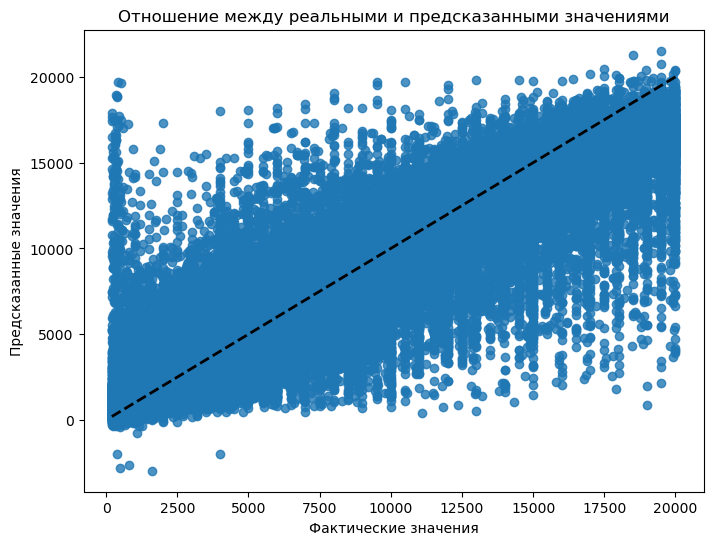

In [116]:
predict_true_plot(y_train, y_cat_pred)

График отношения между реальными и предсказанными значениями для модели CatBoost напоминает график для модели LightGBM: СatBoost тоже плохо определяет дешевый сегмент, но наклон графика немного отличается от линии идеальных предсказаний, рассеяние значений сильнее. 

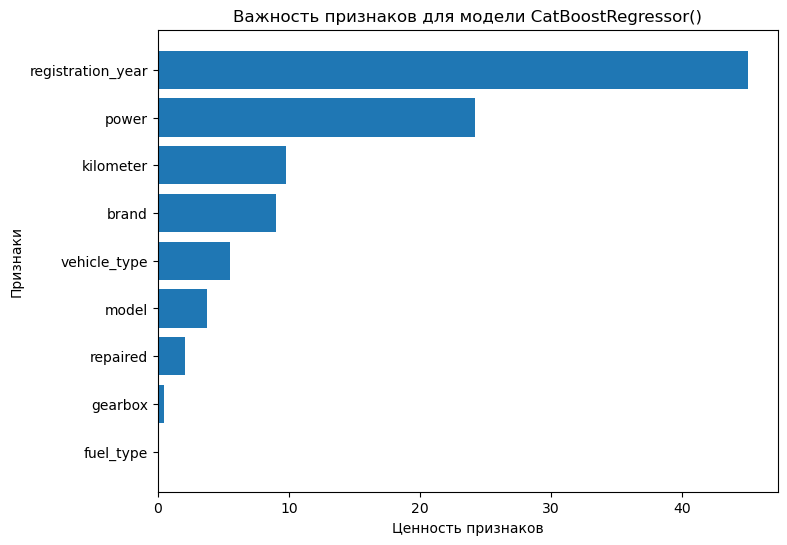

In [117]:
cat_importance = best_model_cat.get_feature_importance()
cat_feature_names = X_train.columns
importance_cat = pd.DataFrame({
    'Признак': cat_feature_names,
    'Важность': cat_importance
}).sort_values(by='Важность', ascending=False)

plt.figure(figsize=(8, 6))
plt.barh(importance_cat['Признак'], importance_cat['Важность'])
plt.xlabel('Ценность признаков')
plt.ylabel('Признаки')
plt.title('Важность признаков для модели CatBoostRegressor()')
plt.gca().invert_yaxis()
plt.show()

Модель CatBoost определила свой набор наиболее важных признаков - среди них год регистрации, мощность двигателя, пробег и бренд авто. По сравнению с LGBM меньшее значение в относительном отношении имеет мощность двигателя и модель.

**Вывод:**  Модель Ridge по метрике RMSE показала значительно худшие результаты по сравнению с градиентным бустингом, также мы столкнулись с большим количеством предсказаний отрицательной цены. Но время обучения и предсказания у бустинговых моделей гораздо больше, чем у простой модели линейной регресии.

## Анализ моделей

In [118]:
models_results = {
    'Модель': names + ['LGBMRegressor', 'CatBoostRegressor'],
    'Время обучения (сек)': fit_times +[LGBMR_fit_time, cat_fit_time],
    'Время предсказания (сек)': score_times + [LGBMR_pred_time, cat_pred_time],
    'RMSE на кросс-валидации': scores + [rmse_LGBMR, rmse_cat]
}
models_results_df = pd.DataFrame(models_results)
models_results_df

Модель  Время обучения (сек)  Время предсказания (сек)  \
0   LinearRegression              2.460578                  0.225439   
1              Ridge              2.282195                  0.224426   
2         ElasticNet              4.745617                  0.356621   
3      LGBMRegressor              4.000634                  4.227224   
4  CatBoostRegressor            139.192758                  0.293024   

   RMSE на кросс-валидации  
0              2291.822073  
1              2291.866688  
2              2294.528789  
3              1649.176338  
4              1735.618146

Все три модели линейной регрессии показали очень хорошие результаты по времени обучения и предсказания, особенно гребеневая регрессия (Ridge) но они имеют худшую оценку точности: предсказания моделей значительно отличаются от реальных значений, средняя ошибка этих моделей самая высокая. CatBoostRegressor, хотя и обучается дольше, чем модели линейной регрессии и LGBMRegressor, но быстрее, чем LGBMRegressor делает предсказания - по сравнению с временем предсказания LGBMRegressor этот результат можно назвать почти мгновенным. LGBMRegressor имеет наилучшее значение RMSE, что означает наименьшую среднеквадратичную ошибку и лучшую точность предсказаний по сравнению с другими моделями, но предсказывает LGBMRegressor за сопоставимо большой период. Значение RMSE для CatBoostRegressor чуть хуже, чем у LGBMRegressor. 

Учитывая все результаты, самой оптимальной моделью для прогнозирования цен на автомобили является LGBMRegressor с 1000 деревьев в ансамбле и коэффициентом L2-регуляризации 0,1.

Сделаем финальное предсказание на тестовых данных.

In [119]:
for c in categorical_feature_names:
    X_test[c] = X_test[c].astype('category')

In [120]:
y_LGBMR_pred_test = best_model_LGBMR.predict(X_test)

In [121]:
print(f'Метрика RMSE на тестовой выборке: {rmse(y_test, y_LGBMR_pred_test)}')

Метрика RMSE на тестовой выборке: 1656.0370615825182


Сравним качество предсказаний с базовой моделью DummyRegressor.

In [122]:
dummy_reg = DummyRegressor(strategy='mean')
dummy_reg.fit(X_train, y_train)
y_pred_dummy = dummy_reg.predict(X_test)
print(f'Метрика RMSE при использовании базовых предсказаний среднего значения:: {rmse(y_test, y_pred_dummy)}')

Метрика RMSE при использовании базовых предсказаний среднего значения:: 4640.324480987551


Сравнивая среднюю ошибку LGBMRegressor с ошибкой базовой модели (которая всегда предсказывает среднее значение), можем сделать вывод, что модель LGBMRegressor гораздо лучше справляется с предсказаниями, чем использование базовых предсказаний среднего значения.